In [55]:
import os
import sys
import pywt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import astropy
from astropy import stats
import geopy
from geopy import distance
import math
from itertools import combinations

import scipy
from scipy import signal
from scipy import fft
from scipy import integrate

import cycler
from matplotlib import cm

import glob

# Eventually will fix this so that notebook is more streamlined...
#path to directory containing hdf files
file_path = 'WindHDFFiles/Speed+Direction/'

#Get a list of all the .hdf files in the directory
WIND_files = glob.glob(file_path + '*.hdf')
N=len(WIND_files)

dfs=np.empty((N, 0)).tolist()

#only problem is this is sorted by alphabetical order instead of by date... will fix at some point 
for i in range (1,N):
    dfs[i]=pd.read_hdf(WIND_files[i])

In [61]:
def scatter_box(ax, x, y_data, xwidth=0.3, ywidth=0.1, color='black', edgecolor='none', flipxy=False, shading='95conf', alpha=0.3, markersize=5, linewidth=1, marker_linewidth=0, use='median', optimize_scatter_distance=False, optimize_scatter_distance_resolution=20, optimize_scatter_distance_y_scale=1, hide_markers=False, scatter_color=None, scatter_cmap='jet', scatter_norm_minmax=[0,1], random_scatter=True, rasterized=True):
    '''
    shading - can show quartiles, or 95% conf, or none
    optimize_scatter_distance - maximize distance between points, instead of randomizing. May take a long time.
    '''  
    if not hasattr(x,'__len__'):
        if use=='median':
            mean = np.median(y_data)
        elif use=='mean':
            mean = np.mean(y_data)
        y_data.sort()
        n = len(y_data)
        bottom_quartile = y_data[int(.25*n)]
        top_quartile = y_data[int(.75*n)]
        
        if random_scatter:
            if not optimize_scatter_distance:
                xvals = [x+np.random.random()*xwidth*2-xwidth for yi in range(len(y_data))]
            else:
                xvals = get_optimized_scatter_distance(y_data, xwidth, resolution=optimize_scatter_distance_resolution, y_scale_factor=optimize_scatter_distance_y_scale)
                xvals += x
        else:
            xvals = [x+0 for yi in range(len(y_data))]

        if shading == '95conf':
            import flystat.resampling
            conf_interval = flystat.resampling.bootstrap_confidence_intervals_from_data(y_data, use=use)
            
        
        if not flipxy:  
            if shading != 'none':
                ax.hlines([mean], x-xwidth, x+xwidth, colors=[color], linewidth=linewidth)
            if shading == 'quartiles':
                ax.fill_between([x-xwidth,x+xwidth], [bottom_quartile, bottom_quartile], [top_quartile, top_quartile], facecolor=color, edgecolor='none', alpha=alpha)
            elif shading == '95conf':
                ax.fill_between([x-xwidth,x+xwidth], [conf_interval[0], conf_interval[0]], [conf_interval[1], conf_interval[1]], facecolor=color, edgecolor='none', alpha=alpha)
            if not hide_markers:
                if scatter_color is not None: # len is a check to rgb tuples
                    ax.scatter(xvals, y_data, s=markersize, c=scatter_color, marker='o', cmap=scatter_cmap, linewidths=marker_linewidth, edgecolors=edgecolor, vmin=scatter_norm_minmax[0], vmax=scatter_norm_minmax[1], rasterized=rasterized)
                else:
                    ax.plot(xvals, y_data, 'o', markerfacecolor=color, markeredgecolor=edgecolor, markersize=markersize, rasterized=rasterized)
        else:
            if shading != 'none':
                ax.vlines([mean], x-xwidth, x+xwidth, colors=[color], linewidth=linewidth)
            if shading == 'quartiles':
                ax.fill_betweenx([x-xwidth,x+xwidth], [bottom_quartile, bottom_quartile], [top_quartile, top_quartile], facecolor=color, edgecolor='none', alpha=alpha)
            elif shading == '95conf':
                ax.fill_betweenx([x-xwidth,x+xwidth], [conf_interval[0], conf_interval[0]], [conf_interval[1], conf_interval[1]], facecolor=color, edgecolor='none', alpha=alpha)
            if not hide_markers:
                if hasattr(color, '__iter__') and len(color) > 3: # len is a check to rgb tuples
                    ax.scatter(y_data, xvals, s=markersize, c=scatter_color, marker='o', cmap=scatter_cmap, linewidths=marker_linewidth, edgecolors=edgecolor, vmin=scatter_norm_minmax[0], vmax=scatter_norm_minmax[1], rasterized=rasterized)
                else:
                    ax.plot(y_data, xvals, 'o', markerfacecolor=color, markeredgecolor=edgecolor, markersize=markersize, rasterized=rasterized)
            
    else:
        for i in range(len(x)):
            if use=='median':
                mean = np.median(y_data[i])
            elif use=='mean':
                mean = np.mean(y_data[i])
            y_data[i].sort()
            n = len(y_data[i])
            bottom_quartile = y_data[i][int(.25*n)]
            top_quartile = y_data[i][int(.75*n)]
            
            if not optimize_scatter_distance:
                xvals = [x[i]+np.random.random()*xwidth*2-xwidth for yi in range(len(y_data))]
            else:
                xvals = get_optimized_scatter_distance(y_data, xwidth, resolution=optimize_scatter_distance_resolution, y_scale_factor=optimize_scatter_distance_y_scale)
                xvals += x[i]
                

            if shading == '95conf':
                import flystat.resampling
                conf_interval = flystat.resampling.bootstrap_confidence_intervals_from_data(y_data[i], use=use)
            
            if not flipxy:
                if shading != 'none':
                    ax.hlines([mean], x[i]-xwidth, x[i]+xwidth, colors=[color], linewidth=linewidth)
                if shading == 'quartiles':
                    ax.fill_between([x[i]-xwidth,x[i]+xwidth], [bottom_quartile, bottom_quartile], [top_quartile, top_quartile], facecolor=color, edgecolor='none', alpha=alpha)
                elif shading == '95conf':
                    ax.fill_between([x-xwidth,x+xwidth], [conf_interval[0], conf_interval[0]], [conf_interval[1], conf_interval[1]], facecolor=color, edgecolor='none', alpha=alpha)
                if not hide_markers:
                    if hasattr(color, '__iter__') and len(color) > 3: # len is a check to rgb tuples
                        ax.scatter(xvals, y_data, s=markersize, c=scatter_color, marker='o', cmap=scatter_cmap, linewidths=marker_linewidth, edgecolors=edgecolor, vmin=scatter_norm_minmax[0], vmax=scatter_norm_minmax[1], rasterized=rasterized)
                    else:
                        ax.plot(xvals, y_data, 'o', markerfacecolor=color, markeredgecolor=edgecolor, markersize=markersize, rasterized=rasterized)
            else:
                if shading != 'none':
                    ax.vlines([mean], x[i]-xwidth, x[i]+xwidth, colors=[color], linewidth=linewidth)
                if shading == 'quartiles':
                    ax.fill_betweenx([x[i]-xwidth,x[i]+xwidth], [bottom_quartile, bottom_quartile], [top_quartile, top_quartile], facecolor=color, edgecolor='none', alpha=alpha)
                elif shading == '95conf':
                    ax.fill_betweenx([x-xwidth,x+xwidth], [conf_interval[0], conf_interval[0]], [conf_interval[1], conf_interval[1]], facecolor=color, edgecolor='none', alpha=alpha)
                if not hide_markers:
                    if hasattr(color, '__iter__') and len(color) > 3: # len is a check to rgb tuples
                        ax.scatter(y_data, xvals, s=markersize, c=scatter_color, marker='o', cmap=scatter_cmap, linewidths=marker_linewidth, edgecolors=edgecolor, vmin=scatter_norm_minmax[0], vmax=scatter_norm_minmax[1], rasterized=rasterized)
                    else:
                        ax.plot(y_data, xvals, 'o', markerfacecolor=color, markeredgecolor=edgecolor, markersize=markersize, rasterized=rasterized)
                

# Reading all dfs separately... not efficient but makes manually checking mistakes easier

In [10]:
df1=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_10.20.20windgps_data.hdf')

In [11]:
df2=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_7.7.21windgps_data.hdf')

In [12]:
df3=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_9.26.21windgps_data.hdf')

In [13]:
df4=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_10.29.21windgps_data.hdf')

In [14]:
df5=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_10.30.21windgps_data.hdf')

In [15]:
df6=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_1.8.22windgps_data.hdf')

In [16]:
df7=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_1.11.22windgps_data.hdf')

In [17]:
df8=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_1.15.22windgps_data.hdf')

In [18]:
df9=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_4.30.22windgps_data.hdf')

In [19]:
df10=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_5.1.22windgps_data.hdf')

In [20]:
df11=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_5.2.22windgps_data.hdf')

In [21]:
df12=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_6.1.22windgps_data.hdf')

In [22]:
df13=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_6.3.22windgps_data.hdf')

In [23]:
df14=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_6.7.22windgps_data.hdf')

In [24]:
df15=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_6.8.22windgps_data.hdf')

In [25]:
df16=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_6.22.22windgps_data.hdf')

# Also not efficient, but separating dfs into just speed and direction. Useful for spectral analysis functions below

In [26]:
#if you just want S2
sdf1=df1[['S2_1', 'S2_2', 'S2_4', 'S2_5', 'S2_6', 'S2_7', 'S2_8', 'S2_9']].dropna()
sdf2=df2[['S2_1', 'S2_2', 'S2_3', 'S2_5', 'S2_6', 'S2_9']].dropna()
sdf3=df3[['S2_1', 'S2_2', 'S2_4', 'S2_5', 'S2_6', 'S2_7']].dropna()
sdf4=df4[['S2_1', 'S2_2', 'S2_3', 'S2_5', 'S2_6', 'S2_7']].dropna()
sdf5=df5[['S2_1', 'S2_2', 'S2_3','S2_5', 'S2_6', 'S2_7' ]].dropna()
sdf6=df6[['S2_1', 'S2_2', 'S2_3','S2_5', 'S2_6', 'S2_7' ]].dropna()
sdf7=df7[['S2_1', 'S2_2', 'S2_3', 'S2_4','S2_5', 'S2_6', 'S2_7' ]].dropna()
sdf8=df8[['S2_1', 'S2_2', 'S2_3', 'S2_4','S2_5', 'S2_6', 'S2_7' ]].dropna()
sdf9=df9[['S2_1', 'S2_2', 'S2_3','S2_5', 'S2_6', 'S2_8' ]].dropna()
sdf10=df10[['S2_1', 'S2_2', 'S2_3','S2_5', 'S2_6', 'S2_8' ]].dropna()
sdf11=df11[['S2_1', 'S2_2','S2_5', 'S2_6', 'S2_8' ]].dropna()
sdf12=df12[['S2_1', 'S2_2', 'S2_3','S2_5', 'S2_6', 'S2_7', 'S2_8' ]].dropna()
sdf13=df13[['S2_2', 'S2_3','S2_5', 'S2_6', 'S2_7', 'S2_8' ]].dropna()
sdf14=df14[['S2_2', 'S2_5', 'S2_6', 'S2_7', 'S2_8' ]].dropna()
sdf15=df15[['S2_2', 'S2_5', 'S2_6', 'S2_7', 'S2_8' ]].dropna()
sdf16=df16[['S2_2', 'S2_3', 'S2_5', 'S2_6', 'S2_7', 'S2_8' ]].dropna()

In [27]:
#if you just want D
ddf1=df1[['D_1', 'D_2', 'D_4', 'D_5', 'D_6', 'D_7', 'D_8', 'D_9']].dropna()
ddf2=df2[['D_1', 'D_2', 'D_3', 'D_5', 'D_6', 'D_9']].dropna()
ddf3=df3[['D_1', 'D_2', 'D_4', 'D_5', 'D_6', 'D_7']].dropna()
ddf4=df4[['D_1', 'D_2', 'D_3', 'D_5', 'D_6', 'D_7']].dropna()
ddf5=df5[['D_1', 'D_2', 'D_3','D_5', 'D_6', 'D_7' ]].dropna()
ddf6=df6[['D_1', 'D_2', 'D_3','D_5', 'D_6', 'D_7' ]].dropna()
ddf7=df7[['D_1', 'D_2', 'D_3', 'D_4','D_5', 'D_6', 'D_7' ]].dropna()
ddf8=df8[['D_1', 'D_2', 'D_3', 'D_4','D_5', 'D_6', 'D_7' ]].dropna()
ddf9=df9[['D_1', 'D_2', 'D_3','D_5', 'D_6', 'D_8' ]].dropna()
ddf10=df10[['D_1', 'D_2', 'D_3','D_5', 'D_6', 'D_8' ]].dropna()
ddf11=df11[['D_1', 'D_2','D_5', 'D_6', 'D_8' ]].dropna()
ddf12=df12[['D_1', 'D_2', 'D_3','D_5', 'D_6', 'D_7', 'D_8' ]].dropna()
ddf13=df13[['D_2', 'D_3','D_5', 'D_6', 'D_7', 'D_8' ]].dropna()
ddf14=df14[['D_2', 'D_5', 'D_6', 'D_7', 'D_8' ]].dropna()
ddf15=df15[['D_2', 'D_5', 'D_6', 'D_7', 'D_8' ]].dropna()
ddf16=df16[['D_2', 'D_3', 'D_5', 'D_6', 'D_7', 'D_8' ]].dropna()

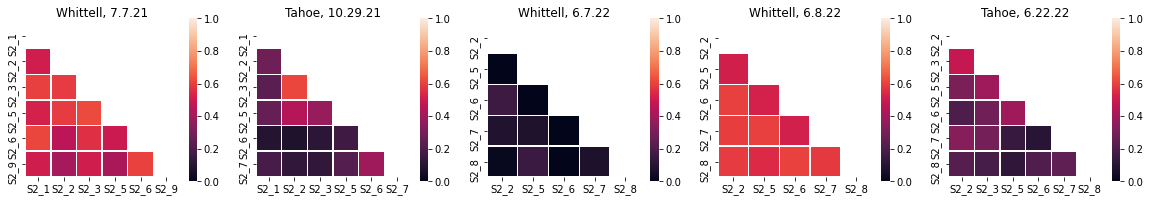

In [196]:
count=1
#plt.subplots(figsize=(10, 8))
#for i in df.columns:
#    plt.subplot(3,2,count)
#    sns.scatterplot(df["cnt"],df[i])


# Set up the matplotlib figure
#f, ax = plt.subplots(nrows=3, figsize=(11, 9))
#plt.subplots(nrows=1, figsize=(11,9))
fig = plt.figure(figsize=(20, 6))
for i in forest:

# Adds subplot on position 1
    #ax[i] = fig.add_subplot(1,6,count)
    # Compute the correlation matrix
    corr = dfs_s2[i].corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Draw the heatmap with the mask and correct aspect ratio
    plt.subplot(1,len(forest),count)
    sns.heatmap(corr, mask=mask, vmax=1, vmin=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(dates[i])
    count+=1
    

# Functions

In [33]:
def get_fft(data,time):
    # Number of sample points
    N = len(time)
    # sample spacing
    time=np.array(time)
    T = 1.0 /(len(time)/(time[-1]-time[0]))
    # print(T)
    x = np.linspace(0.0, N*T, N)
    y = np.array(data)
    yf = scipy.fft.fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
#     p=np.multiply(yf,time[-1])
    X=np.log10(xf[1:])
    Y=np.log10(2.0/N * np.abs(yf[1:(N//2)]))
#     P=np.log10(2.0/N * np.abs(p[1:(N//2)]))
    return(X,Y)

In [34]:
#split speed and difference dfs so that you can find averages on different time chunks
def split_df(df, chunk_size = 6000): #default chunks are 30 min
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks 

In [35]:
def spectrum1(h, dt=.1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

In [36]:
def spectrum2(h, dt=1, nsmooth=5):
    """
    Add simple boxcar smoothing to the raw periodogram.
    
    Chop off the ends to avoid end effects.
    """
    freqs, ps, psd = spectrum1(h, dt=dt)
    weights = np.ones(nsmooth, dtype=float) / nsmooth
    ps_s = np.convolve(ps, weights, mode='valid')
    psd_s = np.convolve(psd, weights, mode='valid')
    freqs_s = np.convolve(freqs, weights, mode='valid')
    return freqs_s, ps_s, psd_s

In [37]:
def spectrum3(h, dt=.1, nsmooth=5):
    """
    Detrend first.
    """
    t = np.arange(len(h))
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return spectrum2(h_detrended, dt=dt, nsmooth=nsmooth)
    

In [38]:
def detrend(h):
    n = len(h)
    t = np.arange(n)
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return h_detrended
    
def quadwin(n):
    """
    Quadratic (or "Welch") window
    """
    t = np.arange(n)
    win = 1 - ((t - 0.5 * n) / (0.5 * n)) ** 2
    return win

def spectrum4(h, dt=.1, nsmooth=5):
    """
    Detrend and apply a quadratic window.
    """
    n = len(h)

    h_detrended = detrend(h)
    
    winweights = quadwin(n)
    h_win = h_detrended * winweights
    
    freqs, ps, psd = spectrum3(h_win, dt=dt, nsmooth=nsmooth)
    
    # Compensate for the energy suppressed by the window.
    psd *= n / (winweights**2).sum()
    ps *= n**2 / winweights.sum()**2
    
    return freqs, ps, psd

In [39]:
def avg_psd(array):
    chunks=split_df(array)
    N=len(chunks)-1
    freqs=np.empty((N, 0)).tolist()
    ps=np.empty((N, 0)).tolist()
    psd=np.empty((N, 0)).tolist()
    
    for i in range (0, N):
        freqs[i], ps[i], psd[i] =spectrum1(chunks[i], dt=.1)
    
    
    
    arrays = [np.array(x) for x in freqs]
    #freqs_avgdf=pd.DataFrame(arrays)
    #freqs_avg=freqs_avgdf.mean()
    
    #freqs_avg= [np.mean(k,dtype=np.float64) for k in zip(*arrays)] 
    freqs_median= [np.median(k) for k in zip(*arrays)] 
    
    arrays2 = [np.array(x) for x in psd]
    #psd_avgdf=pd.DataFrame(arrays2)
    #psd_avg=psd_avgdf.mean()

    #psd_avg= [np.mean(k,dtype=np.float64) for k in zip(*arrays2)] 
    psd_median= [np.median(k) for k in zip(*arrays2)] 
    return freqs_median,psd_median
    #return freqs, psd

def avgdf_psd (df):
    N=len(df.columns)
    all_df_freq=np.empty((N, 0)).tolist()
    all_df_psd=np.empty((N, 0)).tolist()
    
    for i in range (0,N):
        all_df_freq[i], all_df_psd[i] =avg_psd(df.iloc[:,i])

    arrays = [np.array(x) for x in  all_df_freq]
    
    
    freqs_avg= [np.mean(k,dtype=np.float64) for k in zip(*arrays)] 
    #freqs_median= [np.median(k,dtype=np.float64) for k in zip(*arrays)] 
    
    #freqs_avgdf=pd.DataFrame(arrays)
    #freqs_avg=freqs_avgdf.mean()
    arrays2 = [np.array(x) for x in all_df_psd]
    #psd_avgdf=pd.DataFrame(arrays2)
    #psd_avg=psd_avgdf.mean()
    psd_avg= [np.mean(k,dtype=np.float64) for k in zip(*arrays2)] 


    #return freqs_avg,psd_avg
    return freqs_avg, psd_avg

In [40]:
def unwrap_angle (directionarray, degrees=True):
    if (degrees==False):
        directionarray=+math.pi
    else:
        newdirection=directionarray*math.pi/180-math.pi
    return np.unwrap(newdirection)

def rewrap_angle(unwrappedarray, degrees=True):
    rewrapped = (unwrappedarray + np.pi) % (2 * np.pi)
    #same as np.arctan(np.cos(unwrappedarray), np.sin(unwrappedarray))
    if degrees:
        return rewrapped #this is in radians not degrees
    else:
        return rewrapped*180/math.pi

In [41]:
def unwrap_angulardf (directiondf, degrees=True):
    M=len(directiondf.columns)
    unwrappeddf=np.empty((M, 0)).tolist()
    for i in range (0,M):
        unwrappeddf[i]=unwrap_angle(directiondf.iloc[:,i])
    return pd.DataFrame(unwrappeddf, index=directiondf.columns).T    

# Analysis

In [42]:
freq=np.empty((16, 0)).tolist()
psd=np.empty((16, 0)).tolist()
delta_power=np.empty((16, 0)).tolist()
freq_D=np.empty((16, 0)).tolist()
newfreq_D=np.empty((16, 0)).tolist()
psd_D=np.empty((16, 0)).tolist()

In [48]:
delta_power_D=np.empty((16, 0)).tolist()

In [43]:
dfs_s2=[sdf1,sdf2,sdf3,sdf4,sdf5,sdf6,sdf7,sdf8,sdf9,sdf10,sdf11,sdf12,sdf13,sdf14,sdf15,sdf16]

In [44]:
dfs_d=[ddf1,ddf2,ddf3,ddf4,ddf5,ddf6,ddf7,ddf8,ddf9,ddf10,ddf11,ddf12,ddf13,ddf14,ddf15,ddf16]

In [45]:
dates=['Desert, 10.20.20', 'Whittell, 7.7.21', 'David yard, 9.26.21', 'Tahoe, 10.29.21', 'Jaleesa yard, 10.30.21', 'Jaleesa yard, 1.8.22', 'Lemmon, 1.11.22', 'Lemmon, 1.15.22', 'Floris yard, 4.30.22', 'Floris yard, 5.1.22', 'Floris yard, 5.2.22', 'Lemmon, 6.1.22', 'Lemmon, 6.3.22', 'Whittell, 6.7.22', 'Whittell, 6.8.22', 'Tahoe, 6.22.22']

In [77]:
dates[12]

'Lemmon, 6.3.22'

In [87]:
desert=(0,6,7,11, 12)
ddates=['10.20.20', '1.11.22', '1.15.22', '6.1.22', '6.3.22']
forest=(1,3,13,14,15)
fdates=['7.7.21', '10.29.21', '6.7.22', '6.8.22', '6.22.22']
urban=(2,4,5,8,9,10)
udates=['9.26.21', '10.30.21', '1.8.22', '4.30.22', '5.1.22', '5.2.22']

In [46]:
N=len(freq_D)

for i in range (0,N):
    freq_D[i], psd_D[i]= avgdf_psd(unwrap_angulardf(dfs_d[i]))

In [47]:
for i in range (0,16):
    freq[i], psd[i]= avgdf_psd(dfs_s2[i])
    #plt.loglog(freq[i], psd[i])
    #plt.loglog(freq1[i], psd1[i])

In [59]:
# Frequency resolution
freq_res = .1  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve

for i in range (0,16):
    delta_power[i] = scipy.integrate.simps(psd[i], dx=.1)
    delta_power_D[i] = scipy.integrate.simps(psd_D[i], dx=.1)
    print("Absolute delta power" "(speed):", delta_power[i],  "(direction):", delta_power_D[i], dates[i])
    #print("Absolute delta power (direction):", delta_power_D[i],  " ", dates[i])

Absolute delta power(speed): 13.945613810251102 (direction): 1.987603986335479 Desert, 10.20.20
Absolute delta power(speed): 37.392094323637764 (direction): 679.3788817468323 Whittell, 7.7.21
Absolute delta power(speed): 22.786943477893274 (direction): 6325.553089086814 David yard, 9.26.21
Absolute delta power(speed): 3.155571543086444 (direction): 1159.0295953872123 Tahoe, 10.29.21
Absolute delta power(speed): 4.3240842800335395 (direction): 5234.585860075782 Jaleesa yard, 10.30.21
Absolute delta power(speed): 4.758667340395225 (direction): 6952.859349599545 Jaleesa yard, 1.8.22
Absolute delta power(speed): 8.608803456578247 (direction): 1089.6991594431377 Lemmon, 1.11.22
Absolute delta power(speed): 9.423896084885714 (direction): 1843.5180657742892 Lemmon, 1.15.22
Absolute delta power(speed): 44.74969217695937 (direction): 2450.79971125028 Floris yard, 4.30.22
Absolute delta power(speed): 14.12674637341761 (direction): 3333.5889355813188 Floris yard, 5.1.22
Absolute delta power(speed

In [71]:
for i in desert:
    scatter_box(ax=1, x=dates[i], y_data=delta_power[i])

IndexError: invalid index to scalar variable.

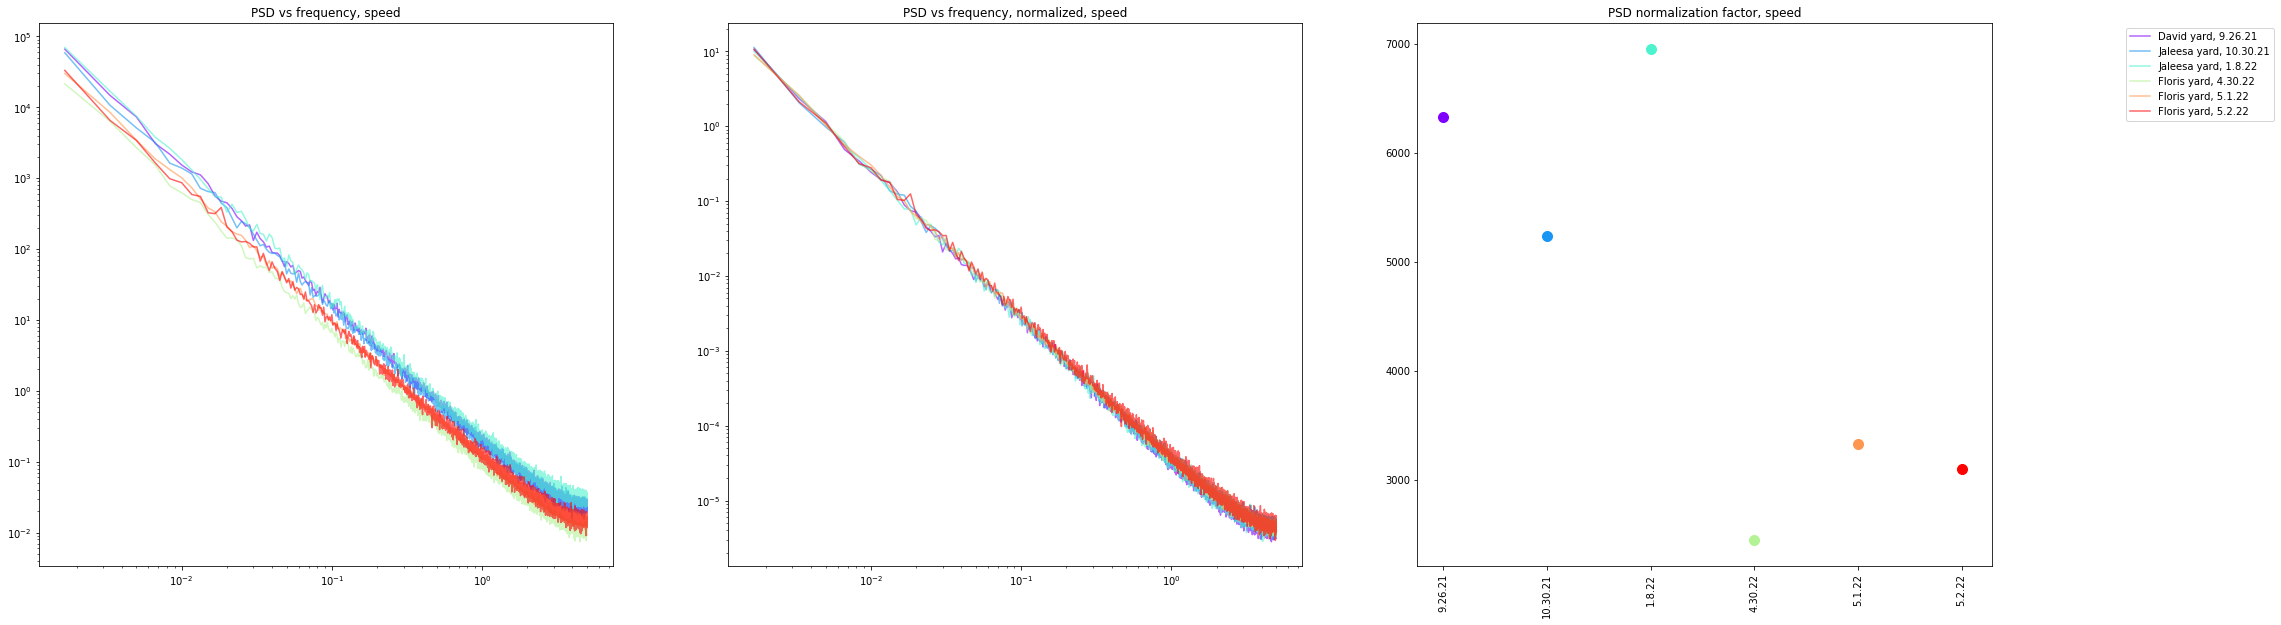

In [102]:
fig, ax =plt.subplots(nrows=1, ncols=3, figsize=(35, 10))
N=len(psd)
j=0
color = iter(cm.rainbow(np.linspace(0, 1, 6)))

for i in urban:
    c = next(color)
    ax[j].loglog(freq_D[i], psd_D[i], color=c, label=dates[i], alpha=.6)
    ax[j+1].loglog(freq_D[i], psd_D[i]/delta_power_D[i], color=c, label=dates[i], alpha=.6)
    ax[j+2].scatter(dates[i], delta_power_D[i], s=100, color=c)

    
ax[0].set_title('PSD vs frequency, speed')

ax[1].legend(bbox_to_anchor=(2.7,1))
ax[1].set_title('PSD vs frequency, normalized, speed')

#ax[2].set_ylim(0,11000)
ax[2].set_title('PSD normalization factor, speed')

ax[2].set_xticklabels(labels=udates,rotation = 90);

<ipython-input-808-fbe043b8564d>:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(labels=dates,rotation = 90)


[Text(0, 0, 'Desert, 10.20.20'),
 Text(1, 0, 'Whittell, 7.7.21'),
 Text(2, 0, 'David yard, 9.26.21'),
 Text(3, 0, 'Tahoe, 10.29.21'),
 Text(4, 0, 'Jaleesa yard, 10.30.21'),
 Text(5, 0, 'Jaleesa yard, 1.8.22'),
 Text(6, 0, 'Lemmon, 1.11.22'),
 Text(7, 0, 'Lemmon, 1.15.22'),
 Text(8, 0, 'Floris yard, 4.30.22'),
 Text(9, 0, 'Floris yard, 5.1.22'),
 Text(10, 0, 'Floris yard, 5.2.22'),
 Text(11, 0, 'Lemmon, 6.1.22'),
 Text(12, 0, 'Lemmon, 6.3.22'),
 Text(13, 0, 'Whittell, 6.7.22'),
 Text(14, 0, 'Whittell, 6.8.22'),
 Text(15, 0, 'Tahoe, 6.22.22')]

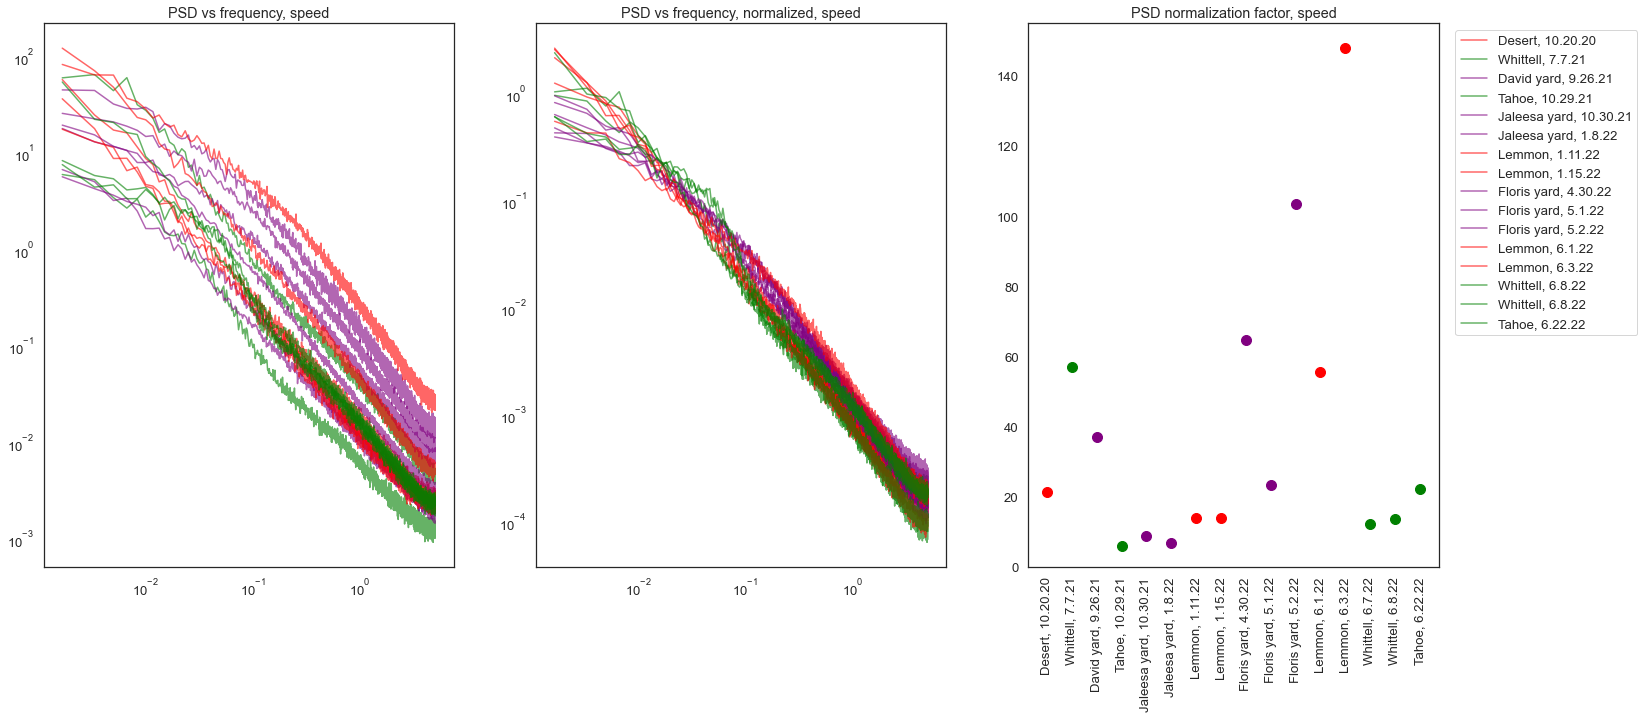

In [808]:
fig, ax =plt.subplots(nrows=1, ncols=3, figsize=(25, 10))


ax[0].loglog(freq[0], psd[0], color='red', label=dates[0], alpha=.6)
ax[0].loglog(freq[1], psd[1], color='green', label=dates[1], alpha=.6)
ax[0].loglog(freq[2], psd[2], color='purple', label=dates[2], alpha=.6)
ax[0].loglog(freq[3], psd[3], color='green', label=dates[3], alpha=.6)
ax[0].loglog(freq[4], psd[4], color='purple', label=dates[4], alpha=.6)
ax[0].loglog(freq[5], psd[5], color='purple', label=dates[5], alpha=.6)
ax[0].loglog(freq[6], psd[6], color='red', label=dates[6], alpha=.6)
ax[0].loglog(freq[7], psd[7], color='red', label=dates[7], alpha=.6)
ax[0].loglog(freq[8], psd[8], color='purple', label=dates[8], alpha=.6)
ax[0].loglog(freq[9], psd[9], color='purple', label=dates[9], alpha=.6)
ax[0].loglog(freq[10], psd[10], color='purple', label=dates[10], alpha=.6)
ax[0].loglog(freq[11], psd[11], color='red', label=dates[11], alpha=.6)
ax[0].loglog(freq[12], psd[12], color='red', label=dates[12], alpha=.6)
ax[0].loglog(freq[13], psd[13], color='green', label=dates[13], alpha=.6)
ax[0].loglog(freq[14], psd[14], color='green', label=dates[14], alpha=.6)
ax[0].loglog(freq[15], psd[15], color='green', label=dates[15], alpha=.6)

ax[0].set_title('PSD vs frequency, speed')


ax[1].loglog(freq[0], psd[0]/delta_power[0], color='red', label=dates[0], alpha=.6)
ax[1].loglog(freq[1], psd[1]/delta_power[1], color='green', label=dates[1], alpha=.6)
ax[1].loglog(freq[2], psd[2]/delta_power[2], color='purple', label=dates[2], alpha=.6)
ax[1].loglog(freq[3], psd[3]/delta_power[3], color='green', label=dates[3], alpha=.6)
ax[1].loglog(freq[4], psd[4]/delta_power[4], color='purple', label=dates[4], alpha=.6)
ax[1].loglog(freq[5], psd[5]/delta_power[5], color='purple', label=dates[5], alpha=.6)
ax[1].loglog(freq[6], psd[6]/delta_power[6], color='red', label=dates[6], alpha=.6)
ax[1].loglog(freq[7], psd[7]/delta_power[7], color='red', label=dates[7], alpha=.6)
ax[1].loglog(freq[8], psd[8]/delta_power[8], color='purple', label=dates[8], alpha=.6)
ax[1].loglog(freq[9], psd[9]/delta_power[9], color='purple', label=dates[9], alpha=.6)
ax[1].loglog(freq[10], psd[10]/delta_power[10], color='purple', label=dates[10], alpha=.6)
ax[1].loglog(freq[11], psd[11]/delta_power[11], color='red', label=dates[11], alpha=.6)
ax[1].loglog(freq[12], psd[12]/delta_power[12], color='red', label=dates[12], alpha=.6)
ax[1].loglog(freq[13], psd[13]/delta_power[13], color='green', label=dates[14], alpha=.6)
ax[1].loglog(freq[14], psd[14]/delta_power[14], color='green', label=dates[14], alpha=.6)
ax[1].loglog(freq[15], psd[15]/delta_power[15], color='green', label=dates[15], alpha=.6)

ax[1].legend(bbox_to_anchor=(2.7,1))
ax[1].set_title('PSD vs frequency, normalized, speed')

ax[2].set_ylim(0,155)
ax[2].scatter(dates[0], delta_power[0], s=100, color='red')
ax[2].scatter(dates[1],delta_power[1], s=100, color='green')
ax[2].scatter(dates[2], delta_power[2], s=100, color='purple')

ax[2].scatter(dates[3], delta_power[3], s=100, color='green')
ax[2].scatter(dates[4], delta_power[4], s=100, color='purple')
ax[2].scatter(dates[5], delta_power[5], s=100, color='purple')
ax[2].scatter(dates[6], delta_power[6], s=100, color='red')
ax[2].scatter(dates[7], delta_power[7], s=100, color='red')
ax[2].scatter(dates[8], delta_power[8], s=100, color='purple')
ax[2].scatter(dates[9],delta_power[9], s=100, color='purple')
ax[2].scatter(dates[10], delta_power[10], s=100, color='purple')
ax[2].scatter(dates[11], delta_power[11], s=100, color='red')
ax[2].scatter(dates[12],delta_power[12], s=100, color='red')
ax[2].scatter(dates[13],delta_power[13], s=100, color='green')
ax[2].scatter(dates[14],delta_power[14], s=100, color='green')
ax[2].scatter(dates[15],delta_power[15], s=100, color='green')
ax[2].set_title('PSD normalization factor, speed')
#xlabels = ax[1].get_xticklabels()
ax[2].set_xticklabels(labels=dates,rotation = 90)





<ipython-input-780-9c3598b0914a>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(labels=dates,rotation = 90)


[Text(0, 0, 'Desert, 10.20.20'),
 Text(1, 0, 'Whittell, 7.7.21'),
 Text(2, 0, 'David yard, 9.26.21'),
 Text(3, 0, 'Tahoe, 10.29.21'),
 Text(4, 0, 'Jaleesa yard, 10.30.21'),
 Text(5, 0, 'Jaleesa yard, 1.8.22'),
 Text(6, 0, 'Lemmon, 1.11.22'),
 Text(7, 0, 'Lemmon, 1.15.22'),
 Text(8, 0, 'Floris yard, 4.30.22'),
 Text(9, 0, 'Floris yard, 5.1.22'),
 Text(10, 0, 'Floris yard, 5.2.22'),
 Text(11, 0, 'Lemmon, 6.1.22'),
 Text(12, 0, 'Lemmon, 6.3.22'),
 Text(13, 0, 'Whittell, 6.7.22'),
 Text(14, 0, 'Whittell, 6.8.22'),
 Text(15, 0, 'Tahoe, 6.22.22')]

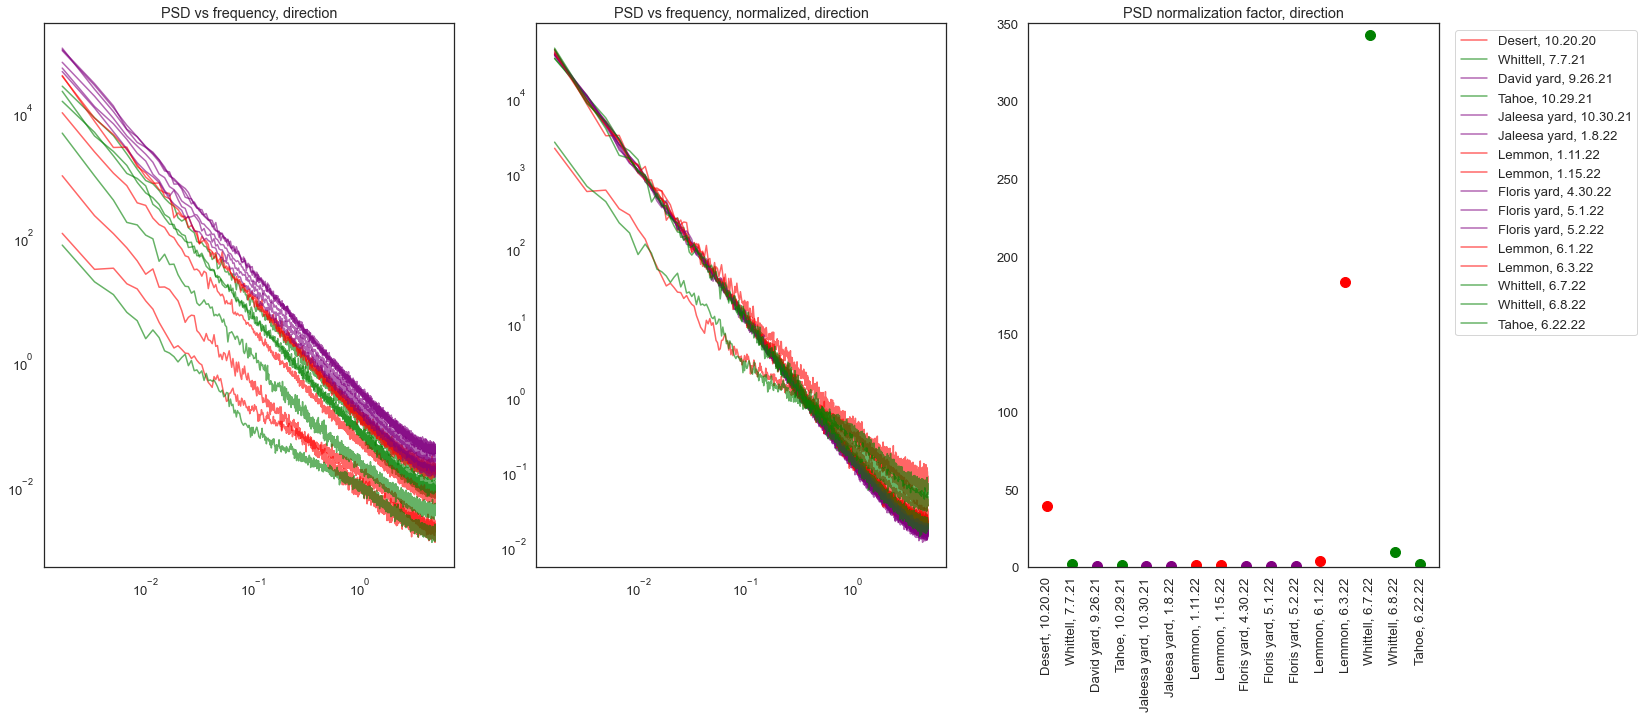

In [780]:
fig, ax =plt.subplots(nrows=1, ncols=3, figsize=(25, 10))


ax[0].loglog(freq_D[0], psd_D[0], color='red', label=dates[0], alpha=.6)
ax[0].loglog(freq_D[1], psd_D[1], color='green', label=dates[1], alpha=.6)
ax[0].loglog(freq_D[2], psd_D[2], color='purple', label=dates[2], alpha=.6)
ax[0].loglog(freq_D[3], psd_D[3], color='green', label=dates[3], alpha=.6)
ax[0].loglog(freq_D[4], psd_D[4], color='purple', label=dates[4], alpha=.6)
ax[0].loglog(freq_D[5], psd_D[5], color='purple', label=dates[5], alpha=.6)
ax[0].loglog(freq_D[6], psd_D[6], color='red', label=dates[6], alpha=.6)
ax[0].loglog(freq_D[7], psd_D[7], color='red', label=dates[7], alpha=.6)
ax[0].loglog(freq_D[8], psd_D[8], color='purple', label=dates[8], alpha=.6)
ax[0].loglog(freq_D[9], psd_D[9], color='purple', label=dates[9], alpha=.6)
ax[0].loglog(freq_D[10], psd_D[10], color='purple', label=dates[10], alpha=.6)
ax[0].loglog(freq_D[11], psd_D[11], color='red', label=dates[11], alpha=.6)
ax[0].loglog(freq_D[12], psd_D[12], color='red', label=dates[12], alpha=.6)
ax[0].loglog(freq_D[13], psd_D[13], color='green', label=dates[13], alpha=.6)
ax[0].loglog(freq_D[14], psd_D[14], color='green', label=dates[14], alpha=.6)
ax[0].loglog(freq_D[15], psd_D[15], color='green', label=dates[15], alpha=.6)

ax[0].set_title('PSD vs frequency, direction')


ax[1].loglog(freq_D[0], psd_D[0]*np.array(39.13), color='red', label=dates[0], alpha=.6)
ax[1].loglog(freq_D[1], psd_D[1]*np.array(2.2353), color='green', label=dates[1], alpha=.6)
ax[1].loglog(freq_D[2], psd_D[2]*np.array(.3712), color='purple', label=dates[2], alpha=.6)
ax[1].loglog(freq_D[3], psd_D[3]*np.array(1.2638), color='green', label=dates[3], alpha=.6)
ax[1].loglog(freq_D[4], psd_D[4]*np.array(.4011), color='purple', label=dates[4], alpha=.6)
ax[1].loglog(freq_D[5], psd_D[5]*np.array(.38), color='purple', label=dates[5], alpha=.6)
ax[1].loglog(freq_D[6], psd_D[6]*np.array(1.1305), color='red', label=dates[6], alpha=.6)
ax[1].loglog(freq_D[7], psd_D[7]*np.array(1.077), color='red', label=dates[7], alpha=.6)
ax[1].loglog(freq_D[8], psd_D[8]*np.array(.8752), color='purple', label=dates[8], alpha=.6)
ax[1].loglog(freq_D[9], psd_D[9]*np.array(.5693), color='purple', label=dates[9], alpha=.6)
ax[1].loglog(freq_D[10], psd_D[10]*np.array(.7448), color='purple', label=dates[10], alpha=.6)
ax[1].loglog(freq_D[11], psd_D[11]*np.array(3.9751), color='red', label=dates[11], alpha=.6)
#ax[1].loglog(freq_D[12], psd_D[12]*np.array(183.78), color='red', label=dates[12], alpha=.6)
#ax[1].loglog(freq_D[13], psd_D[13]*np.array(342.66), color='green', label=dates[13], alpha=.6)

ax[1].loglog(freq_D[12], psd_D[12]*np.array(18.378), color='red', label=dates[12], alpha=.6)
ax[1].loglog(freq_D[13], psd_D[13]*np.array(34.266), color='green', label=dates[13], alpha=.6)
ax[1].loglog(freq_D[14], psd_D[14]*np.array(9.8656), color='green', label=dates[14], alpha=.6)
ax[1].loglog(freq_D[15], psd_D[15]*np.array(1.9996), color='green', label=dates[15], alpha=.6)

ax[1].legend(bbox_to_anchor=(2.7,1))
ax[1].set_title('PSD vs frequency, normalized, direction')

ax[2].set_ylim(0,350)
ax[2].scatter(dates[0], 39.13, s=100, color='red')
ax[2].scatter(dates[1],2.2353, s=100, color='green')
ax[2].scatter(dates[2], .3712, s=100, color='purple')

ax[2].scatter(dates[3], 1.2638, s=100, color='green')
ax[2].scatter(dates[4], .4011, s=100, color='purple')
ax[2].scatter(dates[5], .38, s=100, color='purple')
ax[2].scatter(dates[6], 1.1305, s=100, color='red')
ax[2].scatter(dates[7], 1.077, s=100, color='red')
ax[2].scatter(dates[8], .8752, s=100, color='purple')
ax[2].scatter(dates[9], .5693, s=100, color='purple')
ax[2].scatter(dates[10], .7448, s=100, color='purple')
ax[2].scatter(dates[11], 3.9751, s=100, color='red')
ax[2].scatter(dates[12],183.78, s=100, color='red')
ax[2].scatter(dates[13], 342.66, s=100, color='green')
ax[2].scatter(dates[14], 9.8656, s=100, color='green')
ax[2].scatter(dates[15], 1.9996, s=100, color='green')
ax[2].set_title('PSD normalization factor, direction')
#xlabels = ax[1].get_xticklabels()
ax[2].set_xticklabels(labels=dates,rotation = 90)




<ipython-input-610-46c8d6ad3406>:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(labels=dates,rotation = 90)


[Text(0, 0, 'Desert, 10.20.20'),
 Text(1, 0, 'Whittell, 7.7.21'),
 Text(2, 0, 'David yard, 9.26.21'),
 Text(3, 0, 'Tahoe, 10.29.21'),
 Text(4, 0, 'Jaleesa yard, 10.30.21'),
 Text(5, 0, 'Jaleesa yard, 1.8.22'),
 Text(6, 0, 'Lemmon, 1.11.22'),
 Text(7, 0, 'Lemmon, 1.15.22'),
 Text(8, 0, 'Floris yard, 4.30.22'),
 Text(9, 0, 'Floris yard, 5.1.22'),
 Text(10, 0, 'Floris yard, 5.2.22'),
 Text(11, 0, 'Lemmon, 6.1.22'),
 Text(12, 0, 'Lemmon, 6.3.22'),
 Text(13, 0, 'Whittell, 6.7.22'),
 Text(14, 0, 'Whittell, 6.8.22'),
 Text(15, 0, 'Tahoe, 6.22.22')]

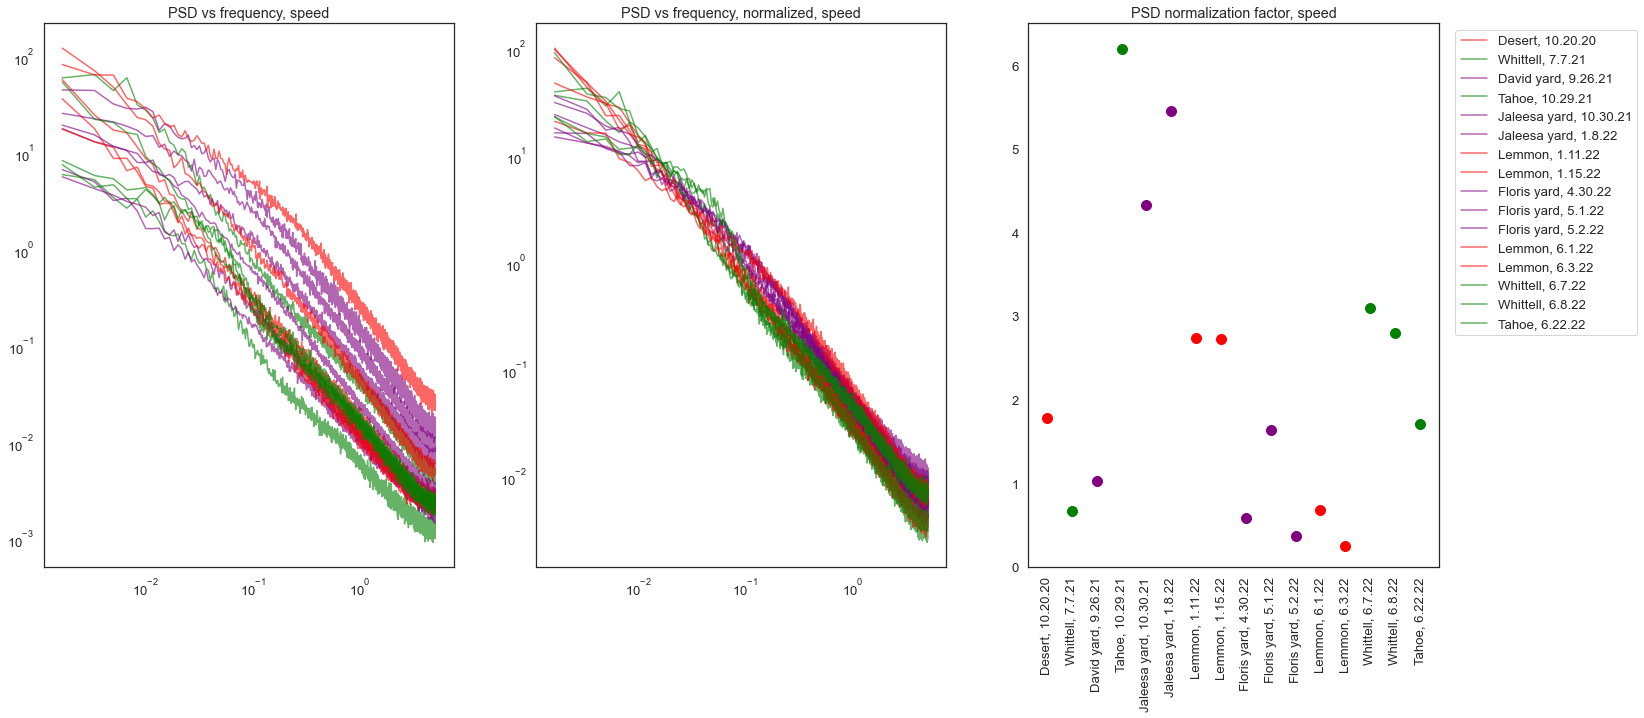

In [610]:
fig, ax =plt.subplots(nrows=1, ncols=3, figsize=(25, 10))


ax[0].loglog(freq[0], psd[0], color='red', label=dates[0], alpha=.6)
ax[0].loglog(freq[1], psd[1], color='green', label=dates[1], alpha=.6)
ax[0].loglog(freq[2], psd[2], color='purple', label=dates[2], alpha=.6)
ax[0].loglog(freq[3], psd[3], color='green', label=dates[3], alpha=.6)
ax[0].loglog(freq[4], psd[4], color='purple', label=dates[4], alpha=.6)
ax[0].loglog(freq[5], psd[5], color='purple', label=dates[5], alpha=.6)
ax[0].loglog(freq[6], psd[6], color='red', label=dates[6], alpha=.6)
ax[0].loglog(freq[7], psd[7], color='red', label=dates[7], alpha=.6)
ax[0].loglog(freq[8], psd[8], color='purple', label=dates[8], alpha=.6)
ax[0].loglog(freq[9], psd[9], color='purple', label=dates[9], alpha=.6)
ax[0].loglog(freq[10], psd[10], color='purple', label=dates[10], alpha=.6)
ax[0].loglog(freq[11], psd[11], color='red', label=dates[11], alpha=.6)
ax[0].loglog(freq[12], psd[12], color='red', label=dates[12], alpha=.6)
ax[0].loglog(freq[13], psd[13], color='green', label=dates[13], alpha=.6)
ax[0].loglog(freq[14], psd[14], color='green', label=dates[14], alpha=.6)
ax[0].loglog(freq[15], psd[15], color='green', label=dates[15], alpha=.6)

ax[0].set_title('PSD vs frequency, speed')


ax[1].loglog(freq[0], psd[0]*np.array(1.77931), color='red', label=dates[0], alpha=.6)
ax[1].loglog(freq[1], psd[1]*np.array(.6663), color='green', label=dates[1], alpha=.6)
ax[1].loglog(freq[2], psd[2]*np.array(1.0264), color='purple', label=dates[2], alpha=.6)
ax[1].loglog(freq[3], psd[3]*np.array(6.2), color='green', label=dates[3], alpha=.6)
ax[1].loglog(freq[4], psd[4]*np.array(4.325), color='purple', label=dates[4], alpha=.6)
ax[1].loglog(freq[5], psd[5]*np.array(5.452), color='purple', label=dates[5], alpha=.6)
ax[1].loglog(freq[6], psd[6]*np.array(2.736), color='red', label=dates[6], alpha=.6)
ax[1].loglog(freq[7], psd[7]*np.array(2.73), color='red', label=dates[7], alpha=.6)
ax[1].loglog(freq[8], psd[8]*np.array(.5885), color='purple', label=dates[8], alpha=.6)
ax[1].loglog(freq[9], psd[9]*np.array(1.6343), color='purple', label=dates[9], alpha=.6)
ax[1].loglog(freq[10], psd[10]*np.array(.36745), color='purple', label=dates[10], alpha=.6)
ax[1].loglog(freq[11], psd[11]*np.array(.6842), color='red', label=dates[11], alpha=.6)
ax[1].loglog(freq[12], psd[12]*np.array(.256753), color='red', label=dates[12], alpha=.6)
ax[1].loglog(freq[13], psd[13]*np.array(3.0921), color='green', label=dates[13], alpha=.6)
ax[1].loglog(freq[14], psd[14]*np.array(2.796), color='green', label=dates[14], alpha=.6)
ax[1].loglog(freq[15], psd[15]*np.array(1.7088), color='green', label=dates[15], alpha=.6)

ax[1].legend(bbox_to_anchor=(2.7,1))
ax[1].set_title('PSD vs frequency, normalized, speed')

ax[2].set_ylim(0,6.5)
ax[2].scatter(dates[0], 1.77931, s=100, color='red')
ax[2].scatter(dates[1],.6663, s=100, color='green')
ax[2].scatter(dates[2], 1.0264, s=100, color='purple')
ax[2].scatter(dates[3], 6.2, s=100, color='green')
ax[2].scatter(dates[4], 4.325, s=100, color='purple')
ax[2].scatter(dates[5], 5.452, s=100, color='purple')
ax[2].scatter(dates[6], 2.736, s=100, color='red')
ax[2].scatter(dates[7], 2.73, s=100, color='red')
ax[2].scatter(dates[8], .5885, s=100, color='purple')
ax[2].scatter(dates[9], 1.6343, s=100, color='purple')
ax[2].scatter(dates[10], .36745, s=100, color='purple')
ax[2].scatter(dates[11], .6842, s=100, color='red')
ax[2].scatter(dates[12], .256753, s=100, color='red')
ax[2].scatter(dates[13], 3.0921, s=100, color='green')
ax[2].scatter(dates[14], 2.796, s=100, color='green')
ax[2].scatter(dates[15], 1.7088, s=100, color='green')
ax[2].set_title('PSD normalization factor, speed')
#xlabels = ax[1].get_xticklabels()
ax[2].set_xticklabels(labels=dates,rotation = 90)




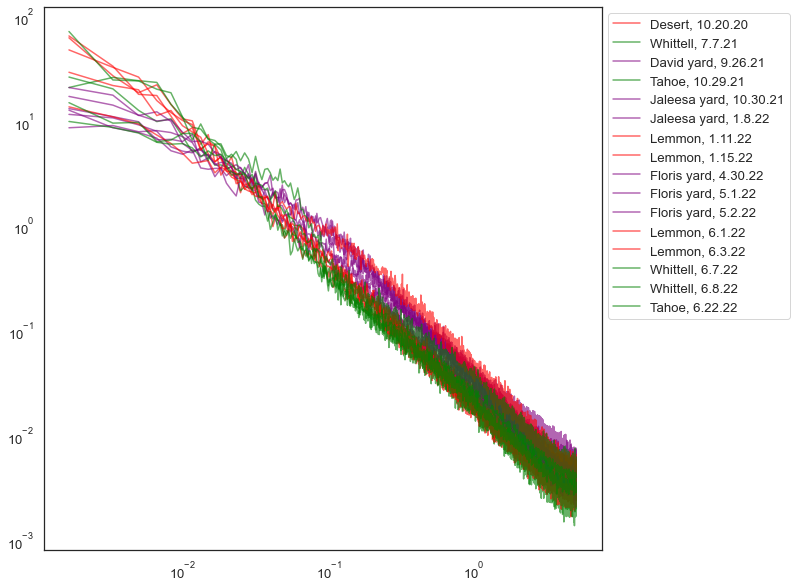

In [928]:
fig=plt.figure(figsize=(10,10))
plt.loglog(freq[0], psd[0]*np.array(1.77931), color='red', label=dates[0], alpha=.6)
plt.loglog(freq[1], psd[1]*np.array(.6663), color='green', label=dates[1], alpha=.6)
plt.loglog(freq[2], psd[2]*np.array(1.0264), color='purple', label=dates[2], alpha=.6)
plt.loglog(freq[3], psd[3]*np.array(6.2), color='green', label=dates[3], alpha=.6)
plt.loglog(freq[4], psd[4]*np.array(4.325), color='purple', label=dates[4], alpha=.6)
plt.loglog(freq[5], psd[5]*np.array(5.452), color='purple', label=dates[5], alpha=.6)
plt.loglog(freq[6], psd[6]*np.array(2.736), color='red', label=dates[6], alpha=.6)
plt.loglog(freq[7], psd[7]*np.array(2.73), color='red', label=dates[7], alpha=.6)
plt.loglog(freq[8], psd[8]*np.array(.5885), color='purple', label=dates[8], alpha=.6)
plt.loglog(freq[9], psd[9]*np.array(1.6343), color='purple', label=dates[9], alpha=.6)
plt.loglog(freq[10], psd[10]*np.array(.36745), color='purple', label=dates[10], alpha=.6)
plt.loglog(freq[11], psd[11]*np.array(.6842), color='red', label=dates[11], alpha=.6)
plt.loglog(freq[12], psd[12]*np.array(.256753), color='red', label=dates[12], alpha=.6)
plt.loglog(freq[13], psd[13]*np.array(3.0921), color='green', label=dates[13], alpha=.6)
plt.loglog(freq[14], psd[14]*np.array(2.796), color='green', label=dates[14], alpha=.6)
plt.loglog(freq[15], psd[15]*np.array(1.7088), color='green', label=dates[15], alpha=.6)

plt.legend(bbox_to_anchor=(1,1))

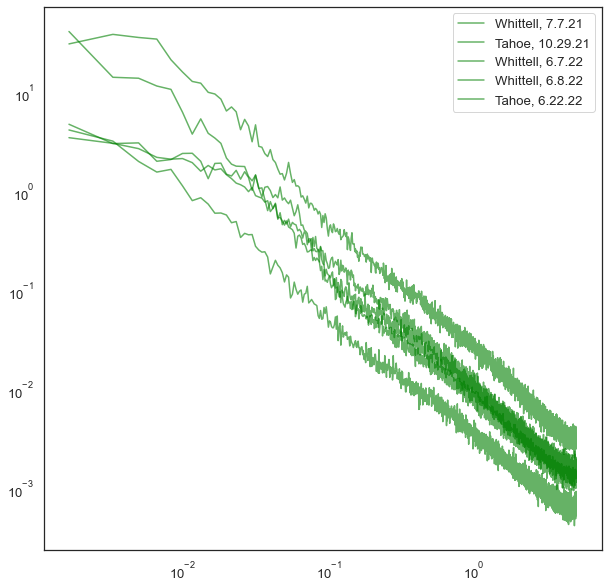

In [937]:
fig=plt.figure(figsize=(10,10))
#plt.loglog(freq[0], psd[0]*np.array(1.77931), color='red', label=dates[0], alpha=.6)
plt.loglog(freq[1], psd[1], color='green', label=dates[1], alpha=.6)
#plt.loglog(freq[2], psd[2]*np.array(1.0264), color='purple', label=dates[2], alpha=.6)
plt.loglog(freq[3], psd[3], color='green', label=dates[3], alpha=.6)
#plt.loglog(freq[4], psd[4]*np.array(4.325), color='purple', label=dates[4], alpha=.6)
#plt.loglog(freq[5], psd[5]*np.array(5.452), color='purple', label=dates[5], alpha=.6)
#plt.loglog(freq[6], psd[6]*np.array(2.736), color='red', label=dates[6], alpha=.6)
#plt.loglog(freq[7], psd[7]*np.array(2.73), color='red', label=dates[7], alpha=.6)
#plt.loglog(freq[8], psd[8]*np.array(.5885), color='purple', label=dates[8], alpha=.6)
#plt.loglog(freq[9], psd[9]*np.array(1.6343), color='purple', label=dates[9], alpha=.6)
#plt.loglog(freq[10], psd[10]*np.array(.36745), color='purple', label=dates[10], alpha=.6)
#plt.loglog(freq[11], psd[11]*np.array(.6842), color='red', label=dates[11], alpha=.6)
#plt.loglog(freq[12], psd[12]*np.array(.256753), color='red', label=dates[12], alpha=.6)
plt.loglog(freq[13], psd[13], color='green', label=dates[13], alpha=.6)
plt.loglog(freq[14], psd[14], color='green', label=dates[14], alpha=.6)
plt.loglog(freq[15], psd[15], color='green', label=dates[15], alpha=.6)

plt.legend(bbox_to_anchor=(1,1))

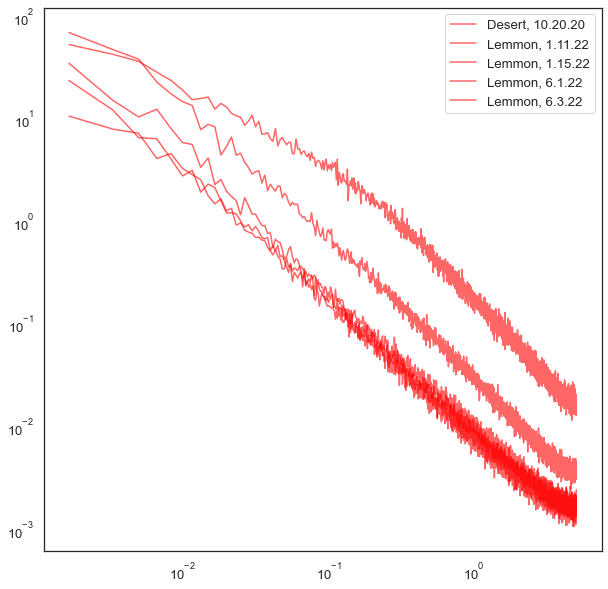

In [936]:
fig=plt.figure(figsize=(10,10))
plt.loglog(freq[0], psd[0], color='red', label=dates[0], alpha=.6)
#plt.loglog(freq[1], psd[1]*np.array(.6663), color='green', label=dates[1], alpha=.6)
#plt.loglog(freq[2], psd[2]*np.array(1.0264), color='purple', label=dates[2], alpha=.6)
#plt.loglog(freq[3], psd[3]*np.array(6.2), color='green', label=dates[3], alpha=.6)
#plt.loglog(freq[4], psd[4]*np.array(4.325), color='purple', label=dates[4], alpha=.6)
#plt.loglog(freq[5], psd[5]*np.array(5.452), color='purple', label=dates[5], alpha=.6)
plt.loglog(freq[6], psd[6], color='red', label=dates[6], alpha=.6)
plt.loglog(freq[7], psd[7], color='red', label=dates[7], alpha=.6)
#plt.loglog(freq[8], psd[8]*np.array(.5885), color='purple', label=dates[8], alpha=.6)
#plt.loglog(freq[9], psd[9]*np.array(1.6343), color='purple', label=dates[9], alpha=.6)
#plt.loglog(freq[10], psd[10]*np.array(.36745), color='purple', label=dates[10], alpha=.6)
plt.loglog(freq[11], psd[11], color='red', label=dates[11], alpha=.6)
plt.loglog(freq[12], psd[12], color='red', label=dates[12], alpha=.6)
#plt.loglog(freq[13], psd[13]*np.array(3.0921), color='green', label=dates[13], alpha=.6)
#plt.loglog(freq[14], psd[14]*np.array(2.796), color='green', label=dates[14], alpha=.6)
#plt.loglog(freq[15], psd[15]*np.array(1.7088), color='green', label=dates[15], alpha=.6)

plt.legend(bbox_to_anchor=(1,1))

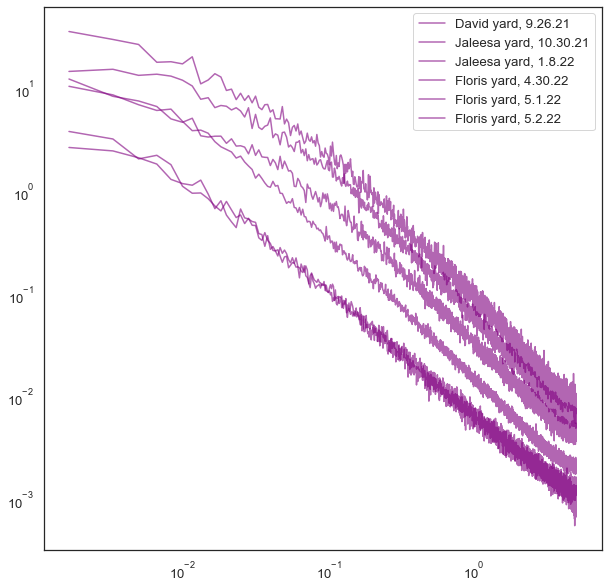

In [935]:
fig=plt.figure(figsize=(10,10))
#plt.loglog(freq[0], psd[0]*np.array(1.77931), color='red', label=dates[0], alpha=.6)
#plt.loglog(freq[1], psd[1]*np.array(.6663), color='green', label=dates[1], alpha=.6)
plt.loglog(freq[2], psd[2], color='purple', label=dates[2], alpha=.6)
#plt.loglog(freq[3], psd[3]*np.array(6.2), color='green', label=dates[3], alpha=.6)
plt.loglog(freq[4], psd[4], color='purple', label=dates[4], alpha=.6)
plt.loglog(freq[5], psd[5], color='purple', label=dates[5], alpha=.6)
#plt.loglog(freq[6], psd[6]*np.array(2.736), color='red', label=dates[6], alpha=.6)
#plt.loglog(freq[7], psd[7]*np.array(2.73), color='red', label=dates[7], alpha=.6)
plt.loglog(freq[8], psd[8], color='purple', label=dates[8], alpha=.6)
plt.loglog(freq[9], psd[9], color='purple', label=dates[9], alpha=.6)
plt.loglog(freq[10], psd[10], color='purple', label=dates[10], alpha=.6)
#plt.loglog(freq[11], psd[11]*np.array(.6842), color='red', label=dates[11], alpha=.6)
#plt.loglog(freq[12], psd[12]*np.array(.256753), color='red', label=dates[12], alpha=.6)
#plt.loglog(freq[13], psd[13]*np.array(3.0921), color='green', label=dates[13], alpha=.6)
#plt.loglog(freq[14], psd[14]*np.array(2.796), color='green', label=dates[14], alpha=.6)
#plt.loglog(freq[15], psd[15]*np.array(1.7088), color='green', label=dates[15], alpha=.6)

plt.legend(bbox_to_anchor=(1,1))

In [260]:
# Relative delta power (expressed as a percentage of total power)
total_power = simps(psd[2], dx=.1)
delta_rel_power = delta_power / total_power
print('Relative delta power: %.3f' % delta_rel_power)

Relative delta power: 1.000


In [266]:
def plot_spectrum_methods(data, sf, window_sec, band=None, dB=False):
    """Plot the periodogram, Welch's and multitaper PSD.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds for Welch's PSD
    dB : boolean
        If True, convert the power to dB.
    """
    from mne.time_frequency import psd_array_multitaper
    from scipy.signal import welch, periodogram
    sns.set(style="white", font_scale=1.2)
    # Compute the PSD
    freqs, psd = periodogram(data, sf)
    freqs_welch, psd_welch = welch(data, sf, nperseg=window_sec*sf)
    psd_mt, freqs_mt = psd_array_multitaper(data, sf, adaptive=True,
                                            normalization='full', verbose=0)
    sharey = False

    # Optional: convert power to decibels (dB = 10 * log10(power))
    if dB:
        psd = 10 * np.log10(psd)
        psd_welch = 10 * np.log10(psd_welch)
        psd_mt = 10 * np.log10(psd_mt)
        sharey = True

    # Start plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=sharey)
    # Stem
    sc = 'slategrey'
    ax1.stem(freqs, psd, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax2.stem(freqs_welch, psd_welch, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax3.stem(freqs_mt, psd_mt, linefmt=sc, basefmt=" ", markerfmt=" ")
    # Line
    lc, lw = 'k', 2
    ax1.plot(freqs, psd, lw=lw, color=lc)
    ax2.plot(freqs_welch, psd_welch, lw=lw, color=lc)
    ax3.plot(freqs_mt, psd_mt, lw=lw, color=lc)
    # Labels and axes
    ax1.set_xlabel('Frequency (Hz)')
    if not dB:
        ax1.set_ylabel('Power spectral density (V^2/Hz)')
    else:
        ax1.set_ylabel('Decibels (dB / Hz)')
    ax1.set_title('Periodogram')
    ax2.set_title('Welch')
    ax3.set_title('Multitaper')
    if band is not None:
        ax1.set_xlim(band)
    ax1.set_ylim(ymin=0)
    ax2.set_ylim(ymin=0)
    ax3.set_ylim(ymin=0)
    sns.despine()

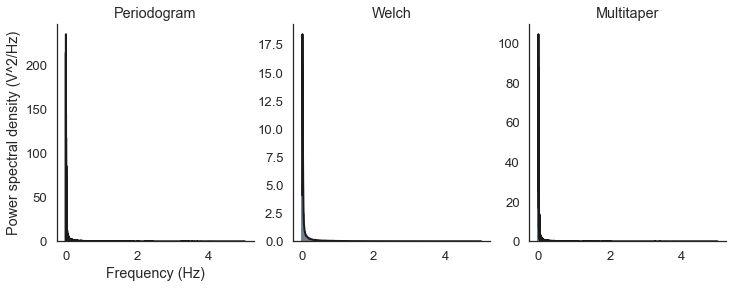

In [271]:
plot_spectrum_methods(df2.S2_1, sf=10, window_sec=100)

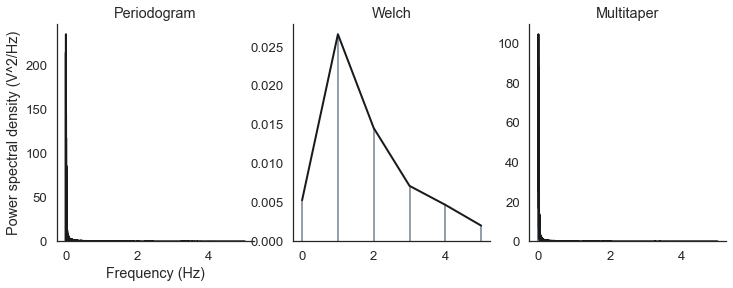

In [270]:
plot_spectrum_methods(df2.S2_1, sf=10, window_sec=100)

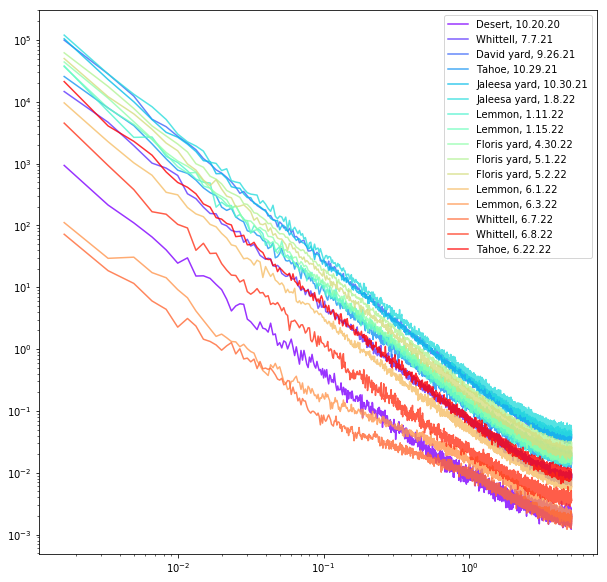

In [85]:
fig=plt.figure(figsize=(10,10))
N=len(freq_D)
color = iter(cm.rainbow(np.linspace(0, 1, N)))

for i in range (0,N):
    c = next(color)
    #freq_D[i], psd_D[i]= avgdf_psd(unwrap_angulardf(dfs_d[i]))
    plt.loglog(freq_D[i], psd_D[i], color=c, label=dates[i], alpha=.8)
    
plt.legend(bbox_to_anchor=(1,1))


In [150]:
t11,t2, t31=spectrum4(sdf2.S2_9)

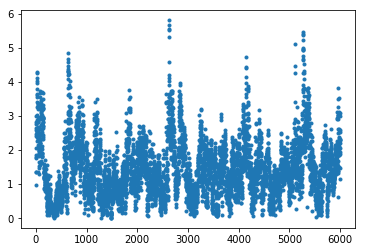

In [162]:
plt.plot(sdf9.S2_2[0:6000], '.')

(0, 100)

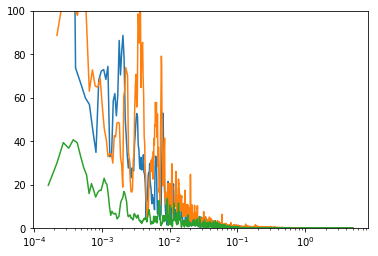

In [152]:
plt.semilogx(t1,t3)
plt.semilogx(t11,t31)
plt.semilogx(t17,t37)
plt.ylim(0,100)

(0, 600000)

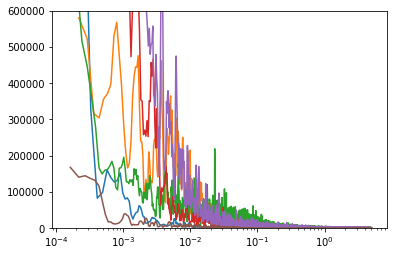

In [139]:
plt.semilogx(t1,t3)
plt.semilogx(t11,t31)
#plt.semilogx(t11u,t31u)
plt.semilogx(t12,t32)
#plt.semilogx(t13,t33)
#plt.semilogx(t14,t34)
plt.semilogx(t15,t35)
plt.semilogx(t16,t36)
plt.semilogx(t17,t37)
plt.ylim(0,600000)

In [35]:
for i in range (0,16):
    #for j in range (0,len(dfs_d[i].columns)):
    freq_Dt[i], ps_Dt[i], psd_Dt[i]= spectrum4(unwrap_angle(dfs_d[i].iloc[:,1]))

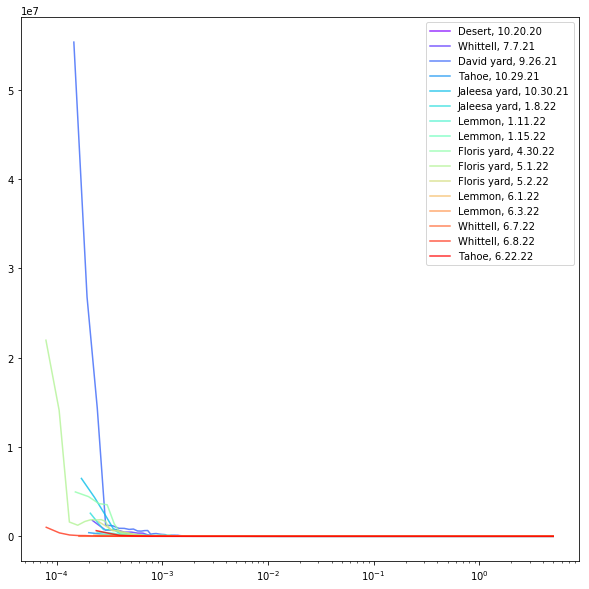

In [41]:
fig=plt.figure(figsize=(10,10))
N=len(freq_Dt)
color = iter(cm.rainbow(np.linspace(0, 1, N)))

for i in range(0,N):
    c = next(color)
    #freq_D[i], psd_D[i]= avgdf_psd(unwrap_angulardf(dfs_d[i]))
    plt.semilogx(freq_Dt[i], psd_Dt[i], color=c, label=dates[i], alpha=.8)
    
plt.legend(bbox_to_anchor=(1,1))    

In [ ]:
fig=plt.figure(figsize=(10,10))
N=len(forest)
color = iter(cm.rainbow(np.linspace(0, 1, N)))

for i in forest:
    c = next(color)
    #freq_D[i], psd_D[i]= avgdf_psd(unwrap_angulardf(dfs_d[i]))
    plt.semilogx(freq_D[i], psd_D[i], color=c, label=dates[i], alpha=.8)
    
plt.legend(bbox_to_anchor=(1,1))    

In [ ]:
fig=plt.figure(figsize=(10,10))
N=len(freq_D)
color = iter(cm.tab20(np.linspace(0, 1, N)))

for i in range (0,N):
    c = next(color)
    #freq_D[i], psd_D[i]= avgdf_psd(unwrap_angulardf(dfs_d[i]))
    plt.loglog(freq_D[i], psd_D[i], color=c, label=dates[i], alpha=.8)
    
plt.legend(bbox_to_anchor=(1,1)) 

In [ ]:
for i in range (0,16):
    freq[i], psd[i]= avgdf_psd(dfs_s2[i])
    #plt.loglog(freq[i], psd[i])
    #plt.loglog(freq1[i], psd1[i])

In [ ]:
fig=plt.figure(figsize=(10,10))

N=len(freqs1)
n=N


color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range (0,n):
    c = next(color)
    #plt.loglog(freq_1[i], psd_1[i], color=c, alpha=.5, label=('unsmoothed', i))
    plt.loglog(freqs1[i], psds1[i], color=c, alpha=.8, label=('smoothed', dates[i]))

plt.loglog(np.array(.90)*freqs1[0], np.array(.90)*psds1[0], color='black', alpha=.8, label=('test'))    

plt.legend(bbox_to_anchor=(1,1))
plt.title('10 min segment PSDs, 1.11.22, direction')

In [ ]:
plt.loglog(freqs1[0],psds1[0], color='blue', alpha=.8, label=('original'))    
plt.loglog(np.array(1)*freqs1[0], np.array(.20)*psds1[0], color='black', alpha=.8, label=('test'))    

In [ ]:
np.array(.1)

In [ ]:
f2,y2=scipy.signal.welch(df2.S2_2, fs=10)

In [ ]:
plt.loglog(f1,y1, color='blue', label='10.20.20')
plt.loglog(f2,y2, color='red', label='7.7.21')
#plt.loglog(f3,y3, color='purple', label='9.26.21')
#plt.loglog(f4,y4, color='red', label='10.29.21')
#plt.loglog(f5,y5, color='purple', label='10.30.21')
#plt.loglog(f6,y6, color='purple', label='1.8.22')
#plt.loglog(f7,y7,color='blue', label='1.11.22')
#plt.loglog(f8,y8,color='blue', label='1.15.22')
#plt.loglog(f9,y9,color='purple', label='4.30.22')
#plt.loglog(f10,y10,color='purple', label='5.1.22')           
#plt.loglog(f11,y11,color='purple', label='5.2.22')           
#plt.loglog(f12,y12,color='blue', label='6.1.22')
#plt.loglog(f13,y13,color='blue', label='6.3.22')           
#plt.loglog(f14,y14,color='red', label='6.7.22')           
#plt.loglog(f15,y15,color='red', label='6.8.22')           
#plt.loglog(f16,y16,color='red', label='6.22.22')
       
plt.legend(bbox_to_anchor=(1,1))

# Plotting

In [40]:
dfs=[df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16]

In [ ]:
fig=plt.figure(figsize=(10,10))

N=len(freq_4)
n=N


color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range (0,n):
    c = next(color)
    #plt.loglog(freq_1[i], psd_1[i], color=c, alpha=.5, label=('unsmoothed', i))
    plt.loglog(freq_4[i], psd_4[i], color=c, alpha=.8, label=('smoothed', i))

plt.legend(bbox_to_anchor=(1,1))
plt.title('10 min segment PSDs, 1.11.22, direction')

In [ ]:
fig=plt.figure(figsize=(10,10))

N=len(freq_4)
n=N


color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range (0,n):
    c = next(color)
    #plt.loglog(freq_1[i], psd_1[i], color=c, alpha=.5, label=('unsmoothed', i))
    plt.loglog(freq_4[i], psd_4[i], color=c, alpha=.8, label=('smoothed', i))

plt.legend(bbox_to_anchor=(1,1))
plt.title('10 min segment PSDs, 10.20.20')

In [ ]:
fig=plt.figure(figsize=(10,10))

N=len(freq_4)
n=N


color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range (0,n):
    c = next(color)
    #plt.loglog(freq_1[i], psd_1[i], color=c, alpha=.5, label=('unsmoothed', i))
    plt.loglog(freq_4[i], psd_4[i], color=c, alpha=.8, label=('smoothed', i))

plt.legend(bbox_to_anchor=(1,1))
plt.title('10 min segment PSDs, 10.29.21')

In [ ]:
fig=plt.figure(figsize=(10,10))

N=len(freq_4)
n=5


color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range (3,8):
    c = next(color)
    #plt.loglog(freq_1[i], psd_1[i], color=c, alpha=.5, label=('unsmoothed', i))
    plt.loglog(freq_4[i], psd_4[i], color=c, alpha=.9, label=('smoothed', i))

plt.legend(bbox_to_anchor=(1,1))
plt.title('10 min segment PSDs, 10.30.21, beginning of day')

In [ ]:
fig=plt.figure(figsize=(10,10))

N=len(freq4)
n=N


color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range (0,N):
    
    c = next(color)
    plt.loglog(freq1[i], psd1[i], color=c, alpha=.5, label=('unsmoothed', dates[i]))
    plt.loglog(freq4[i], psd4[i], color=c, alpha=1, label=('smoothed', dates[i]))
    
plt.legend(bbox_to_anchor=(1,1))
plt.title('10 min avg PSDs for all dfs, smoothed v unsmoothed')

In [ ]:
fig=plt.figure(figsize=(10,10))

N=len(freq)
n=N


color = iter(cm.tab20b(np.linspace(0, 1, 16)))
for i in range (0,N):
    
    c = next(color)
    #plt.loglog(freq1[i], psd1[i], color=c, alpha=.5, label=('unsmoothed', dates[i]))
    plt.loglog(freq[i], psd[i], color=c, alpha=.8, label=(dates[i]))
    
plt.legend(bbox_to_anchor=(1,1))
plt.title('10 min avg PSDs for all dfs, direction')

In [ ]:
fig=plt.figure(figsize=(10,10))

N=len(freqs1)
n=N


color = iter(cm.nipy_spectral(np.linspace(0, 1, 16)))
for i in range (0,N):
    
    c = next(color)
    #plt.loglog(freqs1[i], psds1[i], color=c, alpha=.5, label=('unsmoothed', dates[i]))
    plt.loglog(freq[i], psd[i], color=c, alpha=.8, label=(dates[i]))
    
plt.legend(bbox_to_anchor=(1,1))
plt.title('10 min avg PSDs for all dfs, direction')

In [ ]:
n = 22
color = plt.cm.terrain(np.linspace(0, 1,n))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

In [ ]:
color=['darkred', 'firebrick', 'red', 'tomato', 'indianred', 'darkolivegreen', 'forestgreen', 'mediumseagreen', 'yellowgreen', 'lime', 'darkblue', 'royalblue', 'steelblue', 'paleturquoise', 'darkorchid', 'plum']

#color=['darkred', 'tomato','tomato','tomato','tomato', 'darkolivegreen', 'mediumseagreen','darkolivegreen','darkolivegreen', 'mediumseagreen', 'navy', 'blue', 'blue', 'paleturquoise', 'paleturquoise', 'paleturquoise']
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

In [ ]:
fig,ax=plt.subplots(figsize=(10,10))



plt.loglog(freq[0], psd[0], color='blue', label='Desert, 10.20.20', alpha=.8)
plt.loglog(freq[6], psd[6], color='blue', label='Lemmon, 1.11.22', alpha=.8)
plt.loglog(freq[7],psd[7], color='blue',label='Lemmon, 1.15.22', alpha=.8)
plt.loglog(freq[11], np.array(.4)*psd[11], color='blue', label='Lemmon, 6.1.22', alpha=.8)
plt.loglog(freq[12], np.array(.2)*psd[12], color='blue', label='Lemmon, 6.3.22', alpha=.6)



plt.loglog(freq[1], np.array(.1)*psd[1], color='forestgreen', label='Whittell, 7.7.21', alpha=.6)
plt.loglog(freq[3], psd[3],color='forestgreen', label='Tahoe Forest, 10.29.21', alpha=.6)
plt.loglog(freq[13], psd[13],color='forestgreen', label='Whittell, 6.7.22', alpha=.6)
plt.loglog(freq[14], psd[14],color='forestgreen', label='Whittell, 6.8.22', alpha=.6)
plt.loglog(freq[15], np.array(.2)*psd[15],color='forestgreen', label='Tahoe Forest, 6.22.22', alpha=.6)


plt.loglog(freq[2],np.array(.3)*psd[2], color='purple', label='David Yard, 9.26.21', alpha=.6)
plt.loglog(freq[4], psd[4],color='purple', label='Jaleesa Yard, 10.30.21', alpha=.6)
plt.loglog(freq[5], psd[5],color='purple', label='Jaleesa Yard, 1.8.22', alpha=.6)
plt.loglog(freq[8], np.array(.2)*psd[8],color='purple', label='Floris Yard, 4.30.22', alpha=.6)
plt.loglog(freq[9], np.array(.3)*psd[9],color='purple', label='Floris Yard, 5.1.22', alpha=.6)
plt.loglog(freq[10], np.array(.1)*psd[10],color='purple', label='Floris Yard, 5.2.22', alpha=.6)

#plt.loglog(x, .05*x**m, color='k', linewidth=5, alpha=.7, label='-5/3')

plt.title('10 min PSD averages for backyards')

plt.legend(bbox_to_anchor=(1,1))

In [ ]:

plt.loglog(freq[2], psd[2], color='purple', label='David Yard, 9.26.21', alpha=.6)
plt.loglog(freq[4],psd[4],color='purple', label='Jaleesa Yard, 10.30.21', alpha=.6)
plt.loglog(freq[5], psd[5],color='purple', label='Jaleesa Yard, 1.8.22', alpha=.6)
plt.loglog(freq[8], psd[8],color='purple', label='Floris Yard, 4.30.22', alpha=.6)
plt.loglog(freq[9], psd[9],color='purple', label='Floris Yard, 5.1.22', alpha=.6)
plt.loglog(freq[10], psd[10],color='purple', label='Floris Yard, 5.2.22', alpha=.6)


plt.legend(bbox_to_anchor=(1,1))


In [ ]:
new=np.empty((16, 0)).tolist()

In [ ]:
for i in range (0,16):
    new[i]=np.mean(psd[i])
    plt.scatter([i],new[i], label=(dates[i]))
    
plt.legend(bbox_to_anchor=(1,1))    

In [ ]:
plt.plot(new, '.')

In [ ]:
fig=plt.figure(figsize=(10,6))
plt.loglog(freq[2], psd[2], label='9.26.21')
plt.loglog(freq[4], psd[4], label='10.30.21')
plt.loglog(freq[5], psd[5], label='1.8.22')
plt.loglog(freq[8], psd[8], label='4.30.22')
plt.loglog(freq[9], psd[9], label='5.1.22')
plt.loglog(freq[10], psd[10], label='5.2.22')

plt.loglog(freq1[2], psd1[2], label='9.26.21', alpha=.5)
plt.loglog(freq1[4], psd1[4], label='10.30.21', alpha=.5)
plt.loglog(freq1[5], psd1[5], label='1.8.22', alpha=.5)
plt.loglog(freq1[8], psd1[8], label='4.30.22', alpha=.5)
plt.loglog(freq1[9], psd1[9], label='5.1.22', alpha=.5)
plt.loglog(freq1[10], psd1[10], label='5.2.22', alpha=.5)

plt.legend(bbox_to_anchor=(1,1))

In [ ]:
fig=plt.figure(figsize=(10,10))

plt.loglog(freq[1], psd[1], label='7.7.21')
plt.loglog(freq[3], psd[3], label='10.29.21')
plt.loglog(freq[13], psd[13], label='6.7.22')
plt.loglog(freq[14], psd[14], label='6.8.22')
plt.loglog(freq[15], psd[15], label='6.22.22')

plt.legend(bbox_to_anchor=(1,1))

In [ ]:
#fig, [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16] = plt.subplots(nrows=16, ncols=1, figsize=(15,35))

fig, [ax2, ax4,  ax14, ax15,  ax16, ] = plt.subplots(nrows=5, ncols=1, figsize=(15,30))


#ax1.scatter(df1.time, df1.D_2, s=1, color='k', label='Desert 10.20.20')
ax2.scatter(df2.time, df2.D_2, s=1, color='k', label='Forest 7.7.21')
#ax3.scatter(df3.time, df3.D_2, s=1, color='k', label='Backyard 9.26.21')
ax4.scatter(df4.time, df4.D_2, s=1, color='k', label='Forest 10.29.21')
#ax5.scatter(df5.time, df5.D_2, s=1, color='k', label='Backyard 10.30.21')
#ax6.scatter(df6.time, df6.D_2, s=1, color='k', label='Backyard 1.8.21')
#ax7.scatter(df7.time, df7.D_2, s=1, color='k', label='Lemmon 1.11.22')
#ax8.scatter(df8.time, df8.D_2, s=1, color='k', label='Lemmon 1.15.22')
#ax9.scatter(df9.time, df9.D_2, s=1, color='k', label='Backyard 4.30.22')
#ax10.scatter(df10.time, df10.D_2, s=1, color='k', label='Backyard 5.1.22')
#ax11.scatter(df11.time, df11.D_2, s=1, color='k', label='Backyard 5.2.22')
#ax12.scatter(df12.time, df12.D_2, s=1, color='k', label='Lemmon 6.1.22')
#ax13.scatter(df13.time, df13.D_5, s=1, color='k', label='Lemmon 6.3.22')
ax14.scatter(df14.time, df14.D_5, s=1, color='k', label='Forest 6.7.22')
ax15.scatter(df15.time, df15.D_5, s=1, color='k', label='Forest 6.8.22')
ax16.scatter(df16.time, df16.D_5, s=1, color='k', label='Forest 6.22.22')

#ax1.legend(bbox_to_anchor=(1,1))
ax2.legend(bbox_to_anchor=(1.16,1))
#ax3.legend(bbox_to_anchor=(1.16,1))
ax4.legend(bbox_to_anchor=(1.16,1))
#ax5.legend(bbox_to_anchor=(1.16,1))
#ax6.legend(bbox_to_anchor=(1.16,1))
#ax7.legend(bbox_to_anchor=(1.16,1))
#ax8.legend(bbox_to_anchor=(1.16,1))
#ax9.legend(bbox_to_anchor=(1.16,1))
#ax10.legend(bbox_to_anchor=(1.16,1))
#ax11.legend(bbox_to_anchor=(1.16,1))
#ax12.legend(bbox_to_anchor=(1,1))
#ax13.legend(bbox_to_anchor=(1,1))
ax14.legend(bbox_to_anchor=(1.16,1))
ax15.legend(bbox_to_anchor=(1.16,1))
ax16.legend(bbox_to_anchor=(1,1))